In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import mapclassify

plt.style.use('default')
# This next line tells jupyter to render the images inline
%matplotlib inline
import matplotlib_inline
# This renders your figures as vector graphics AND gives you an option to download a PDF too
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [2]:
trax1_df = pd.read_csv('data/aq_data/TRX01_2021_08.csv')
trax2_df = pd.read_csv('data/aq_data/TRX02_2021_08.csv')
trax3_df = pd.read_csv('data/aq_data/TRX03_2021_08.csv')
#bus1_df = pd.read_csv('data/aq_data/BUS01_2021_08.csv')

In [38]:
trax1_df.columns

Index(['index', 'Timestamp_UTC', 'Latitude_ddeg', 'Longitude_ddeg',
       'Elevation_m', 'Battery_Voltage_volts', 'Train_Box_Temperature_degC',
       'Train_Top_Relative_Humidity_%', 'Train_Top_Temperature_degC',
       'ES642_PM2.5_Concentration_ug/m3', 'ES642_Air_Flow_Rate_L/min',
       'ES642_Internal_Air_Temperature_degC',
       'ES642_Internal_Relative_Humidity_%', 'ES642_Internal_Air_Pressure_hpa',
       'ES642_Error_Code_code', '2B_Ozone_Concentration_ppbv',
       '2B_Air_Flow_Rate_L/min', '2B_Internal_Air_Temperature_degC',
       '2B_Internal_Air_Pressure_hpa', 'PM2.5_Data_Flagged_binary',
       'Ozone_Data_Flagged_binary', 'Time_Tuple', 'Date', 'Year', 'Month',
       'Day_of_Year', 'Day_of_Month', 'Minute'],
      dtype='object')

In [3]:
#trax1_df['Hour']

In [4]:
#investigate_date = "2022-01-13" ##Bad Air day from initial explore of dataset -- solid East/West discrepancy
#investigate_date = "2023-09-01" ##Dust Day from Trib Article -- ugh. Perfect air
#investigate_date = '2022-01-11' ##Inversion day from my photos. Air not great, but yellow all around. Possibly better on the west side?
#investigate_date = '2021-08-05' ## possibly a solid example of west/east discrepancy a day before the bad smoke came into town
investigate_date = '2021-08-06'

trax1_df = trax1_df[trax1_df['Date'] == investigate_date].reset_index()
trax2_df = trax2_df[trax2_df['Date'] == investigate_date].reset_index()
trax3_df = trax3_df[trax3_df['Date'] == investigate_date].reset_index()
#bus1_df = bus1_df[bus1_df['Date'] == investigate_date].reset_index()

#put all these data frames into one
concat_df = pd.concat([trax1_df, trax2_df, trax3_df], ignore_index=True)#, bus1_df], ignore_index=True)
""" 
concat_df['Timestamp_UTC'] = pd.to_datetime(concat_df['Timestamp_UTC'])
concat_df['Hour'] = concat_df['Timestamp_UTC'].apply(lambda x: x.timetuple().tm_hour)
concat_df['Timestamp_UTC'] = concat_df['Timestamp_UTC'].astype(str) 
"""

" \nconcat_df['Timestamp_UTC'] = pd.to_datetime(concat_df['Timestamp_UTC'])\nconcat_df['Hour'] = concat_df['Timestamp_UTC'].apply(lambda x: x.timetuple().tm_hour)\nconcat_df['Timestamp_UTC'] = concat_df['Timestamp_UTC'].astype(str) \n"

In [76]:
concat_df['AQI'] = concat_df['ES642_PM2.5_Concentration_ug/m3'].apply(lambda x: 
                                                                  'Good' if x < 12 
                                                                        else ('Moderate' if x < 35.5 
                                                                              else ('Unhealthy for Sensitive Groups' if x < 55.5 
                                                                                    else ('Unhealthy' if x < 150.5
                                                                                          else ('Very Unhealthy' if x < 250.5 
                                                                                                else 'Hazardous')))))

concat_df['PM2.5_Category'] = concat_df['ES642_PM2.5_Concentration_ug/m3'].apply(lambda x:
                                                                                 '< 12.00' if x < 12.00
                                                                                    else ('12.00 - 35.50' if x < 35.50
                                                                                          else('35.50 - 85.50' if x < 85.50
                                                                                                else('115.00 - 150.50') if x < 150.50
                                                                                                      else('150.50+'))))


concat_df['Meso_West_Category'] = concat_df['ES642_PM2.5_Concentration_ug/m3'].apply(lambda x:
                                                                                 '< 2.00' if x < 2.00
                                                                                    else ('2.00 - 4.00' if x < 4.00
                                                                                    else('4.00 - 6.00' if x < 6.00
                                                                                    else('6.00 - 8.00') if x < 8.00
                                                                                    else('8.00 - 10.00') if x < 10.00
                                                                                    else('10.00 - 12.00') if x < 12.00
                                                                                    else('12.00 - 20.00') if x < 20.00
                                                                                    else('20.00 - 28.00') if x < 28.00
                                                                                    else('28.00 - 35.50') if x < 35.50
                                                                                    else('35.50 - 45.50') if x < 45.50
                                                                                    else('45.50 - 55.50') if x < 55.50
                                                                                    else('55.50 - 85.50') if x < 85.50
                                                                                    else('85.50 - 115.50') if x < 115.50
                                                                                    else('115.50 - 150.50') if x < 150.50
                                                                                    else('150.50+'))))

In [77]:
AQI_category = CategoricalDtype(categories=["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous"], ordered=True)
PM25_Category = CategoricalDtype(categories=["< 12.00", "12.00 - 35.50", "35.50 - 85.50", "115.00 - 150.50", "150.50+"], ordered=True)
MesoWest_Category = CategoricalDtype(categories=['< 2.00', '2.00 - 4.00', '4.00 - 6.00', '6.00 - 8.00', '8.00 - 10.00','10.00 - 12.00','12.00 - 20.00','28.00 - 35.50','35.50 - 45.50','45.50 - 55.50','55.50 - 85.50','85.50 - 115.50','115.50 - 150.50','150.50+'
], ordered=True)

In [78]:
concat_df['AQI'] = concat_df['AQI'].astype(AQI_category)
concat_df['PM2.5_Category'] = concat_df['PM2.5_Category'].astype(PM25_Category)
concat_df['Meso_West_Category'] = concat_df['Meso_West_Category'].astype(MesoWest_Category)

In [79]:
check = concat_df.sort_values(by=['ES642_PM2.5_Concentration_ug/m3'], ascending=False).reset_index()
check = check[['ES642_PM2.5_Concentration_ug/m3','AQI','PM2.5_Category']]
check

ES642_PM2.5_Concentration_ug/m3        AQI PM2.5_Category
0                               358.0  Hazardous        150.50+
1                               348.0  Hazardous        150.50+
2                               345.0  Hazardous        150.50+
3                               305.0  Hazardous        150.50+
4                               302.0  Hazardous        150.50+
...                               ...        ...            ...
3450                              2.0       Good        < 12.00
3451                              2.0       Good        < 12.00
3452                              2.0       Good        < 12.00
3453                              2.0       Good        < 12.00
3454                              1.0       Good        < 12.00

[3455 rows x 3 columns]

In [80]:
geo_df = gpd.GeoDataFrame(
    concat_df,
    geometry=gpd.points_from_xy(concat_df.Longitude_ddeg, concat_df.Latitude_ddeg),
    crs='EPSG:4326'
)

In [81]:
#concat_df = concat_df[concat_df['Hour'] == 12]
#concat_df

In [82]:
""" fig, ax = plt.subplots(figsize=(7,7))
slv = cx.Place(search="Salt Lake", source=cx.providers.CartoDB.Positron, zoom=12)
slv.plot(ax = ax)

geo_df.to_crs(epsg=3857).plot(
    ax=ax,
    column='ES642_PM2.5_Concentration_ug/m3',
    #column='Elevation_m',
    cmap = 'plasma',
    legend=True
) 
 """

' fig, ax = plt.subplots(figsize=(7,7))\nslv = cx.Place(search="Salt Lake", source=cx.providers.CartoDB.Positron, zoom=12)\nslv.plot(ax = ax)\n\ngeo_df.to_crs(epsg=3857).plot(\n    ax=ax,\n    column=\'ES642_PM2.5_Concentration_ug/m3\',\n    #column=\'Elevation_m\',\n    cmap = \'plasma\',\n    legend=True\n) \n '

In [83]:
""" def my_colormap(value):  
    if value < 12:
        return "green"
    elif value < 55.5:
        return "yellow"
    elif value < 150.5:
        return "orange"
    elif value < 250.5:
        return "purple"
    else:
        return "maroon" """

' def my_colormap(value):  \n    if value < 12:\n        return "green"\n    elif value < 55.5:\n        return "yellow"\n    elif value < 150.5:\n        return "orange"\n    elif value < 250.5:\n        return "purple"\n    else:\n        return "maroon" '

In [84]:
trax1_df

index        Timestamp_UTC  Latitude_ddeg  Longitude_ddeg  Elevation_m  \
0     3689  2021-08-06 04:22:00      40.721138     -111.918999       1306.0   
1     3690  2021-08-06 04:23:00      40.722149     -111.920425       1284.8   
2     3691  2021-08-06 04:24:00      40.722076     -111.920410       1282.2   
3     3692  2021-08-06 04:25:00      40.722149     -111.920433       1282.2   
4     3693  2021-08-06 04:26:00      40.722168     -111.920433       1282.3   
..     ...                  ...            ...             ...          ...   
879   4568  2021-08-06 21:21:00      40.721081     -111.919075       1295.7   
880   4569  2021-08-06 21:22:00      40.721081     -111.919075       1295.9   
881   4570  2021-08-06 21:23:00      40.721081     -111.919075       1296.2   
882   4571  2021-08-06 21:24:00      40.722019     -111.920509       1291.8   
883   4572  2021-08-06 21:25:00      40.723400     -111.921570       1294.9   

     Battery_Voltage_volts  Train_Box_Temperature_degC  \
0                    13.27                       32.26   
1                    13.27                       32.26   
2                    13.26                       32.26   
3                    13.26                       32.30   
4                    13.25                       32.33   
..                     ...                         ...   
879                  13.13                       36.36   
880                  13.14                       36.36   
881                  13.13                       36.36   
882                  13.13                       36.36   
883                  13.13                       36.40   

     Train_Top_Relative_Humidity_%  Train_Top_Temperature_degC  \
0                            21.07                       30.19   
1                            20.77                       30.66   
2                            20.46                       30.80   
3                            20.46                       31.00   
4                            19.99                       31.21   
..                             ...                         ...   
879                          22.25                       28.15   
880                          22.22                       28.12   
881                          22.22                       28.15   
882                          22.70                       28.22   
883                          21.88                       28.39   

     ES642_PM2.5_Concentration_ug/m3  ...  2B_Internal_Air_Pressure_hpa  \
0                                8.0  ...                         814.6   
1                                9.0  ...                         814.6   
2                               10.0  ...                         814.5   
3                                9.0  ...                         814.5   
4                               11.0  ...                         814.5   
..                               ...  ...                           ...   
879                             59.0  ...                         818.7   
880                             60.0  ...                         818.7   
881                             63.0  ...                         818.7   
882                             64.0  ...                         818.7   
883                             69.0  ...                         818.7   

     PM2.5_Data_Flagged_binary  Ozone_Data_Flagged_binary  \
0                            0                          0   
1                            0                          0   
2                            0                          0   
3                            0                          0   
4                            0                          0   
..                         ...                        ...   
879                          0                          0   
880                          0                          0   
881                          0                          0   
882                          0                         

In [85]:
Meso_West_cmap = ['#00FFFF','#00CCFF','#0099FF','#00FF00','#009900','#006600','#FFFF00','#FFE600','#FFCD00','#FF7E00','#FF5000','#FF0000','#990000','#CC0033','#FF00FF']

In [86]:
geo_df.explore(
    #column='AQI',
    column='Meso_West_Category',
    #column='ES642_PM2.5_Concentration_ug/m3',
    #cmap= my_colormap,
    #cmap=['green', 'yellow', 'orange', 'red', 'purple', 'maroon'],
    cmap=Meso_West_cmap,
    marker_type='circle_marker',
    marker_kwds={'radius': 5, 'fill': True, 'alpha': 1},
    style_kwds={'fillOpacity': 1, 'weight': 1, 'color': 'black'},
    tooltip=['ES642_PM2.5_Concentration_ug/m3','AQI', 'Meso_West_Category','PM2.5_Category','Timestamp_UTC'],
)

([], [])

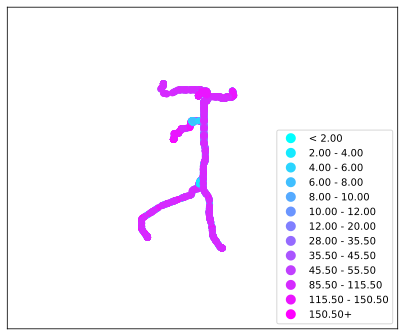

In [73]:
fig, ax = plt.subplots(figsize=(7,7))

geo_df.plot(
    ax=ax,
    column='Meso_West_Category',
    cmap='cool',
    legend=True,
    #move location of legend
    legend_kwds={'loc': 'lower right'},
)


plt.xlim(-112.3, -111.5)
plt.ylim(40.4, 40.9)
plt.xticks([])
plt.yticks([])